#Task-04

Analyze and visualize sentiment patterns in social media data to understand public opinion and attitudes towards specific topics or brands.



Sample Dataset :- https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from torchtext.data.utils import get_tokenizer
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, Dataset
from nltk.probability import FreqDist

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Reading and analysis of data

In [61]:
# Read the data from the file
data = pd.read_csv('twitter_training.csv', header=None, names=['id', 'entity', 'label', 'text'])
data.head()

,id,entity,label,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [62]:
# Data analysis
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74682 non-null  int64 
 1   entity  74682 non-null  object
 2   label   74682 non-null  object
 3   text    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [63]:
data.dropna(inplace=True)

In [64]:
# Unique label values
data['label'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

##Analyze sentiment distribution

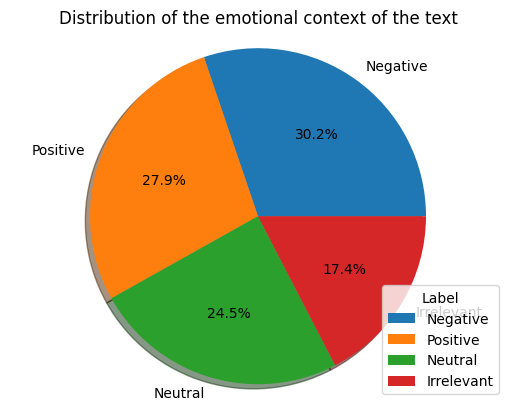

In [65]:
# Distribution of labels in the data
data['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True)
plt.title('Distribution of the emotional context of the text')
plt.axis('equal')
plt.ylabel('')
plt.legend(title='Label', labels=data['label'].value_counts().index)
plt.show()

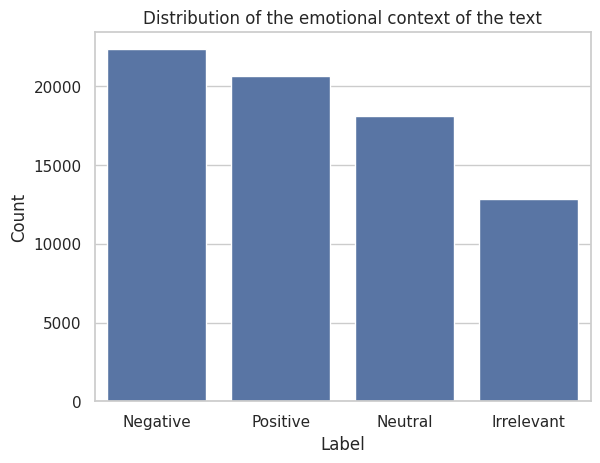

In [70]:
sns.set(style="whitegrid")
sns.barplot(data['label'].value_counts())
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of the emotional context of the text');

In [71]:
positive_posts = data[data['label'] == 'Positive']
positive_posts.head()

,id,entity,label,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


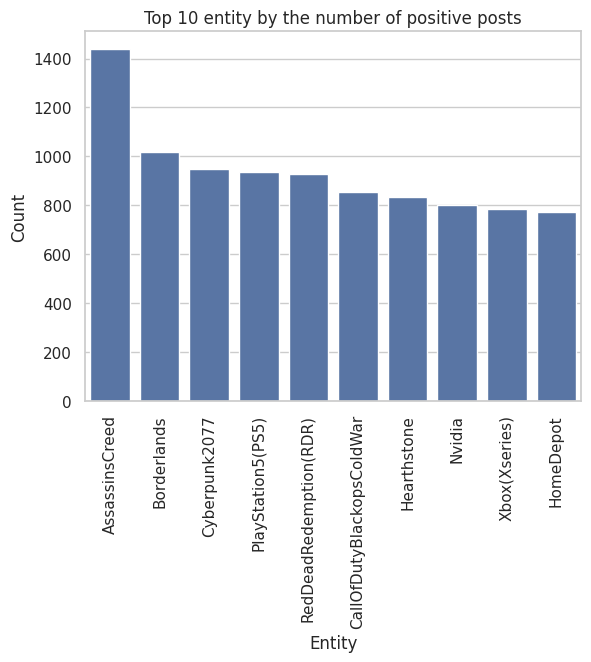

In [84]:
sns.barplot(data[data['label'] == 'Positive'].entity.value_counts()[:10])
plt.title('Top 10 entity by the number of positive posts')
plt.ylabel('Count')
plt.xlabel('Entity')
plt.xticks(rotation=90);

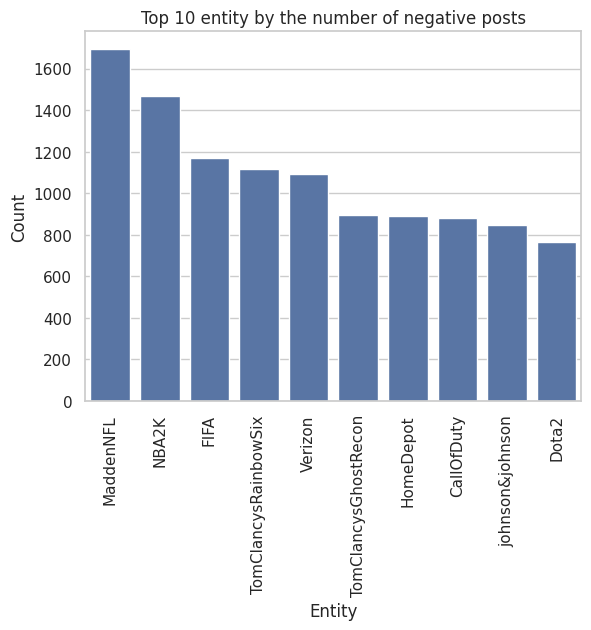

In [86]:
sns.barplot(data[data['label'] == 'Negative'].entity.value_counts()[:10])
plt.title('Top 10 entity by the number of negative posts')
plt.ylabel('Count')
plt.xlabel('Entity')
plt.xticks(rotation=90);

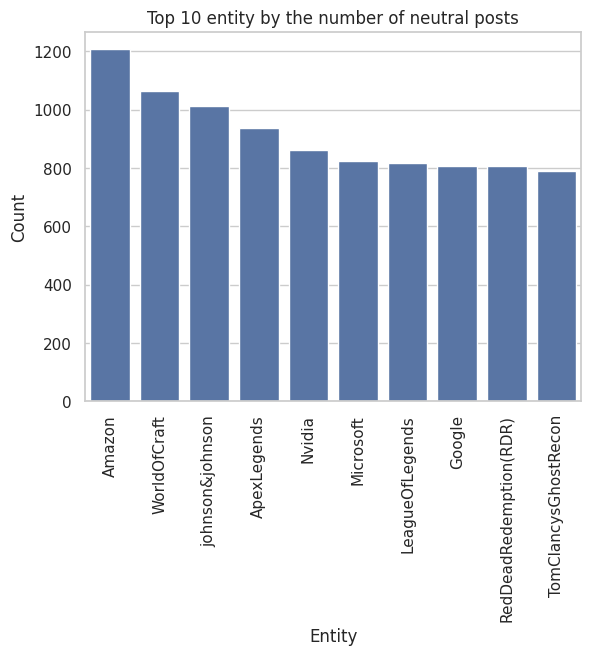

In [112]:
sns.barplot(data[data['label'] == 'Neutral'].entity.value_counts()[:10])
plt.title('Top 10 entity by the number of neutral posts')
plt.ylabel('Count')
plt.xlabel('Entity')
plt.xticks(rotation=90);

##Identifying the most frequently used words in different types of posts

In [116]:
from collections import Counter


def frequently_words(posts, n):
  all_posts = re.sub('[^a-zA-Z ]', '', ' '.join(posts))
  word_counts = Counter([word for word in all_posts.split() if word not in set(stopwords.words("english"))])
  return word_counts.most_common(n)


In [117]:
top_positive_words = frequently_words(data[data['label'] == 'Positive'].text, 10)

In [122]:
print('The most used words in positive posts:', top_positive_words)

The most used words in positive posts: [('I', 8085), ('game', 2095), ('Im', 1501), ('The', 1451), ('love', 1403), ('good', 1315), ('like', 1287), ('really', 1144), ('play', 986), ('new', 965)]


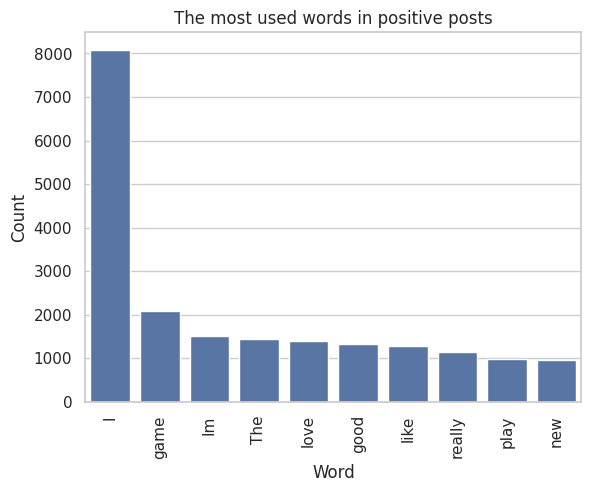

In [137]:
sns.barplot(dict(top_positive_words))
plt.title('The most used words in positive posts')
plt.ylabel('Count')
plt.xlabel('Word')
plt.xticks(rotation=90);

In [138]:
top_negative_words = frequently_words(data[data['label'] == 'Negative'].text, 10)

In [139]:
print('The most used words in negative posts:', top_negative_words)

The most used words in negative posts: [('I', 8680), ('game', 3551), ('get', 1525), ('like', 1496), ('shit', 1350), ('Im', 1150), ('cant', 1124), ('The', 1119), ('play', 1114), ('EAMaddenNFL', 1078)]


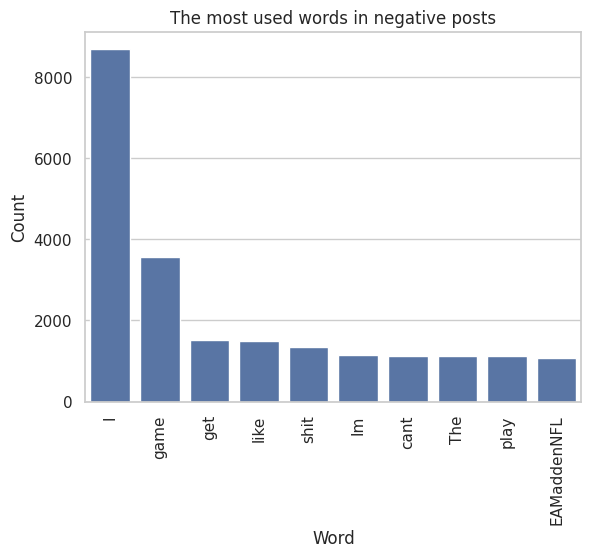

In [140]:
sns.barplot(dict(top_negative_words))
plt.title('The most used words in negative posts')
plt.ylabel('Count')
plt.xlabel('Word')
plt.xticks(rotation=90);

In [141]:
top_neutral_words = frequently_words(data[data['label'] == 'Neutral'].text, 10)

In [142]:
print('The most used words in neutral posts:', top_neutral_words)

The most used words in neutral posts: [('I', 4860), ('Johnson', 1748), ('The', 1684), ('game', 1023), ('Amazon', 969), ('like', 846), ('Im', 769), ('get', 750), ('Facebook', 721), ('Microsoft', 657)]


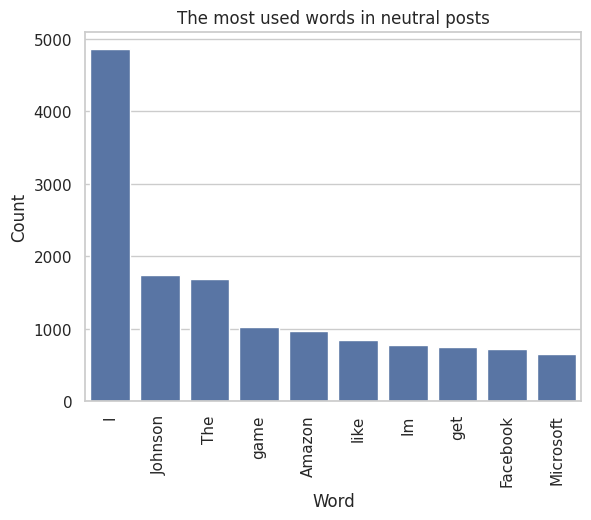

In [143]:
sns.barplot(dict(top_neutral_words))
plt.title('The most used words in neutral posts')
plt.ylabel('Count')
plt.xlabel('Word')
plt.xticks(rotation=90);

##Preprocessing of data for training a model

In [9]:
tokenizer = get_tokenizer("basic_english")
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

In [10]:
def preprocess_sentences(sentence):
    sentence = re.sub('[^a-zA-z.,!?/:;\"\'\s]', '', sentence)
    sentence = re.sub('[^a-zA-Z0-9 ]', '', sentence)
    sentence = sentence.lower()
    tokens = tokenizer(sentence)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    sentence = ' '.join(tokens)
    return sentence

In [11]:
# Preliminary analysis of words in texts for word vectorization
unique_words = set()

for text in data['text']:
    text = preprocess_sentences(text)
    words = text.split()
    unique_words.update(words)

unique_words_list = list(unique_words)

In [12]:
UNK_TOKEN = "<UNK>"
word_to_idx = {word: i for i, word in enumerate(unique_words_list)}
word_to_idx[UNK_TOKEN] = len(word_to_idx)

In [13]:
list(word_to_idx.items())[:10]

[('keynot', 0),
 ('deess', 1),
 ('animalss', 2),
 ('cultureofgamingcom', 3),
 ('frog', 4),
 ('wbpolic', 5),
 ('saha', 6),
 ('disneypoint', 7),
 ('zokjrw', 8),
 ('blake', 9)]

In [14]:
def process_inputs(sentence):
    inputs = torch.LongTensor([word_to_idx.get(word, word_to_idx[UNK_TOKEN]) for word in sentence.split()])
    return inputs

In [15]:
data['text'] = data.text.apply(lambda x: preprocess_sentences(x))
data['text_length'] = data['text'].str.split().apply(len)
data = data[data['text_length'] > 1]
data.head()

,id,entity,label,text,text_length
0,2401,Borderlands,Positive,im get borderland murder,4
1,2401,Borderlands,Positive,come border kill,3
2,2401,Borderlands,Positive,im get borderland kill,4
3,2401,Borderlands,Positive,im come borderland murder,4
4,2401,Borderlands,Positive,im get borderland murder,4


##Model Definition

In [16]:
class TextClassificationCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(TextClassificationCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv1 = nn.Conv1d(embed_dim, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.fc = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, text):
        embedded = self.embedding(text).permute(0, 2, 1)
        conved1 = nn.functional.relu(self.conv1(embedded))
        conved2 = nn.functional.relu(self.conv2(conved1))
        conved3 = nn.functional.relu(self.conv3(conved2))
        pooled = nn.functional.max_pool1d(conved3, kernel_size=conved3.shape[2])
        pooled = pooled.squeeze(2)
        pooled = self.dropout(pooled)
        return self.fc(pooled)

In [17]:
# Dataset class for training data
class TwitterDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        text = sample['text']
        label = sample['label']
        return {'text': text, 'label': label}

In [18]:
# Training parameters
vocab_size = len(unique_words_list) + 1
embed_dim = 100
learning_rate = 0.05
num_epochs = 20
batch_size = 64
num_classes = 4
model = TextClassificationCNN(vocab_size, embed_dim, num_classes)

In [19]:
# Preprocessing labels using LabelEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

In [20]:
# Prepare data for training
dataset = TwitterDataset(data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [21]:
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

##Training the model

In [22]:
for epoch in range(10):
    epoch_loss = 0.0
    for batch in dataloader:
        texts = batch['text']
        labels = batch['label']

        optimizer.zero_grad()
        max_len = max([len(process_inputs(text)) for text in texts])

        # Pad all texts to have the same length
        padded_texts = [torch.cat((process_inputs(text), torch.full((max_len - len(process_inputs(text)),), word_to_idx[UNK_TOKEN], dtype=torch.long))) for text in texts]

        # Stack the padded texts
        inputs = torch.stack(padded_texts)
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Print loss after each epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(dataloader)}')

Epoch 1/20, Loss: 1.3272277523270424
Epoch 2/20, Loss: 1.147896681967027
Epoch 3/20, Loss: 0.9887344232376885
Epoch 4/20, Loss: 0.852300656685496
Epoch 5/20, Loss: 0.7311299786738613
Epoch 6/20, Loss: 0.6255226541748818
Epoch 7/20, Loss: 0.5301429429913268
Epoch 8/20, Loss: 0.4566288097515045
Epoch 9/20, Loss: 0.38741642744828236
Epoch 10/20, Loss: 0.32744554101544265


##Testing the model

In [32]:
# Testing the model on some examples
emotions = label_encoder.classes_

book_reviews = [
   "I love this book",
   "I hate this book"
]
for review in book_reviews:
    inputs = process_inputs(preprocess_sentences(review)).unsqueeze(0)
    outputs = model(inputs)
    _, predicted_label = torch.max(outputs.data, 1)
    sentiment = emotions[predicted_label.item()]
    print(f"Book Review: {review}")
    print(f"Sentiment: {sentiment}\n")


Book Review: I love this book
Sentiment: Positive

Book Review: I hate this book
Sentiment: Negative



In [33]:
test_dataset = pd.read_csv('twitter_validation.csv', header=None, names=['id', 'entity', 'label', 'text'])
test_dataset.head()

,id,entity,label,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [34]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1000 non-null   int64 
 1   entity  1000 non-null   object
 2   label   1000 non-null   object
 3   text    1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [35]:
# Preprocessing of test data
test_dataset['text'] = test_dataset['text'].apply(preprocess_sentences)

In [38]:
from sklearn.metrics import accuracy_score

model.eval()
predicted_labels_test = []
with torch.no_grad():
  for row in test_dataset.iterrows():
    label = row[1].label
    text = row[1].text
    inputs = process_inputs(text).unsqueeze(0)
    if len(inputs[0]) != 0:
      outputs = model(inputs)
      _, predicted_label = torch.max(outputs.data, 1)
      sentiment = emotions[predicted_label.item()]
      predicted_labels_test.append(sentiment)
    else:
      predicted_labels_test.append('Unknown')

# Calculate accuracy
accuracy = accuracy_score(test_dataset.label.values, predicted_labels_test)
print(f'Test accuracy: {accuracy}')

Test accuracy: 0.896


In [56]:
xticks = np.append(label_encoder.classes_, 'Unknown')

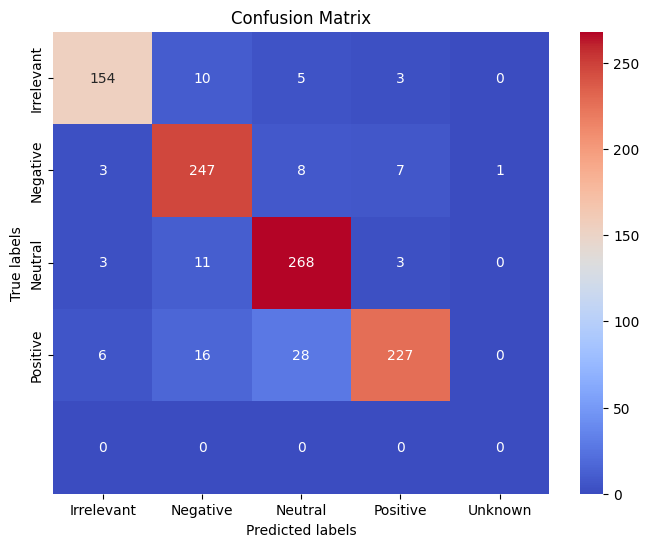

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(test_dataset.label.values, predicted_labels_test)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=xticks, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [37]:
from sklearn.metrics import accuracy_score

model.eval()
predicted_labels_train = []
with torch.no_grad():
  for row in data.iterrows():
    label = row[1].label
    text = row[1].text
    inputs = process_inputs(text).unsqueeze(0)
    outputs = model(inputs)
    _, predicted_label = torch.max(outputs.data, 1)
    sentiment = emotions[predicted_label.item()]
    predicted_labels_train.append(predicted_label)

# Calculate accuracy
accuracy = accuracy_score(data.label.values, predicted_labels_train)
print(f'Train accuracy: {accuracy}')

Train accuracy: 0.8904729739440365


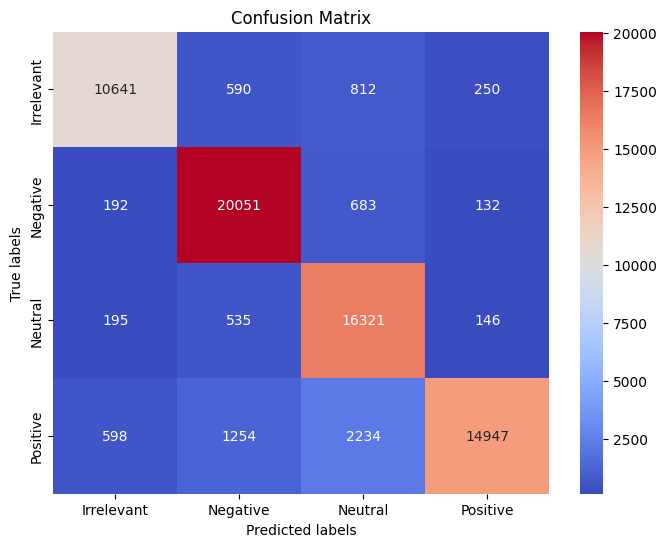

In [59]:
# Compute confusion matrix
conf_matrix = confusion_matrix(data.label.values, predicted_labels_train)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()